In [1]:
from utils import *
import tensorflow as tf
from collections import Counter
from sklearn.cross_validation import train_test_split
import time
from gensim import corpora, models

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
trainset = sklearn.datasets.load_files(container_path = 'data', encoding = 'UTF-8')
trainset.data, trainset.target = separate_dataset(trainset,1.0)
print(trainset.target_names)
print(len(trainset.data))
print(len(trainset.target))

['negative', 'positive']
10662
10662


In [4]:
labels, texts = [], []
max_words = 15
for no, i in enumerate(trainset.data):
    if len(i.split()) > max_words:
        labels.append(trainset.target[no])
        texts.append(i)
        
trainset.data = texts
trainset.target = labels
print(len(trainset.data),len(trainset.target))

1735 1735


In [5]:
texts = ' '.join(trainset.data)
words = texts.split()
word2freq = Counter(words)
word_counts = [count for _, count in word2freq.most_common()]
print("Total words:", len(words))

Total words: 32091


In [6]:
tokenized_docs = [(i, doc.split()) for i, doc in enumerate(trainset.data)]
_words = set(words)
word2idx = {c: i for i, c in enumerate(_words)}
idx2word = {i: c for i, c in enumerate(_words)}
vocab_size = len(idx2word)
indexed = [word2idx[w] for w in words]
encoded_docs = [(i, [word2idx[t] for t in doc]) for i, doc in tokenized_docs]
print('Vocabulary size:', vocab_size)

Vocabulary size: 10626


In [7]:
doc_decoder = {i: doc_id for i, (doc_id, doc) in enumerate(encoded_docs)}

In [8]:
def get_windows(doc,hws=5):
    inside = [(w, doc[(i - hws):i] + doc[(i + 1):(i + hws + 1)]) for i, w in enumerate(doc[hws:-hws], hws)]
    beginning = [(w, doc[:i] + doc[(i + 1):(2*hws + 1)]) for i, w in enumerate(doc[:hws], 0)]
    end = [(w, doc[-(2*hws + 1):i] + doc[(i + 1):]) for i, w in enumerate(doc[-hws:], len(doc) - hws)]
    return inside + beginning + end

In [9]:
data = []
for index, (_, doc) in enumerate(encoded_docs):
    windows = get_windows(doc)
    data += [[index, w[0]] + w[1] for w in windows]
    
data = np.array(data, dtype='int64')
data.shape

(32091, 12)

In [10]:
word_counts = np.array(word_counts)
unigram_distribution = word_counts/sum(word_counts)

In [11]:
%%time
vocab_size = len(idx2word)
embedding_dim = 50

texts = [[str(j) for j in doc] for i, doc in encoded_docs]
model = models.Word2Vec(texts, size=embedding_dim, min_count=1,window=5, workers=4, sg=1, negative=15, iter=70)
model.init_sims(replace=True)

word_vectors = np.zeros((vocab_size, embedding_dim)).astype('float32')
for i in idx2word:
    word_vectors[i] = model.wv[str(i)]

CPU times: user 27.1 s, sys: 16 ms, total: 27.1 s
Wall time: 7.87 s


In [12]:
texts = [[idx2word[j] for j in doc] for i, doc in encoded_docs]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
%%time
n_topics = 25
lda = models.LdaModel(corpus, alpha=0.9, id2word=dictionary, num_topics=n_topics)
corpus_lda = lda[corpus]

CPU times: user 17.4 s, sys: 4 ms, total: 17.4 s
Wall time: 17.4 s


In [14]:
for i, topics in lda.show_topics(n_topics, formatted=False):
    print('topic', i, ':', ' '.join([t for t, _ in topics]))

topic 0 : film movie like one even make time enough story good
topic 1 : one film movie like makes story us characters comedy much
topic 2 : film movie like one story us makes even time characters
topic 3 : film movie one like time story even movies make films
topic 4 : film movie like one story us time good much makes
topic 5 : movie film like story us one much films movies even
topic 6 : film one movie like story way even much comedy director
topic 7 : movie film like one even story good makes time director
topic 8 : film movie like one much story way us films movies
topic 9 : film movie like one make good story much even us
topic 10 : like movie film one story make even films movies us
topic 11 : film like movie one story even characters good films make
topic 12 : film one movie like story us even characters much way
topic 13 : film one movie like even make films makes much little
topic 14 : film movie one like story much even never us films
topic 15 : movie film like one even story

In [15]:
doc_weights_init = np.zeros((len(corpus_lda), n_topics))
for i in range(len(corpus_lda)):
    topics = corpus_lda[i]
    for j, prob in topics:
        doc_weights_init[i, j] = prob

In [16]:
doc_weights_init = np.log(doc_weights_init + 1e-4)
temperature = 7.0
doc_weights_init /= temperature

In [17]:
BETA = 0.75
ETA = 0.4

class Model:
    def __init__(self, data,unigram_distribution, word_vectors,doc_weights_init,
                 n_topics=25, batch_size=15, n_epochs=200,
                 lambda_const=100.0, learning_rate = 1e-3,
                 topics_weight_decay=1e-2,grad_clip=5.0):
        
        vocab_size, embedding_dim = word_vectors.shape
        n_windows = len(data)
        n_documents = len(np.unique(data[:, 0]))
        
        self.DOC_INDEX = tf.placeholder(tf.int32, shape=[None])
        self.WORD_INDEX = tf.placeholder(tf.int32, shape=[None])
        self.TARGET = tf.placeholder(tf.int32, shape=[None,data.shape[1]-2])

        doc_ids = data[:, 0]
        unique_docs, counts = np.unique(doc_ids, return_counts=True)
        weights = np.zeros((len(unique_docs)), 'float32')
        for i, j in enumerate(unique_docs):
            weights[j] = 1.0/np.log(counts[i])
        weights = tf.convert_to_tensor(weights, np.float32)
        
        unigram_distribution /= np.sum(unigram_distribution ** BETA)
        unigram_distribution = tf.convert_to_tensor(unigram_distribution, np.float32)
        
        self.topic_vectors = tf.get_variable('topic_vectors',shape=(n_topics, embedding_dim),
                        initializer=tf.orthogonal_initializer())
        
        alpha = 1.0/n_topics
        self.embedding_doc = tf.convert_to_tensor(doc_weights_init, np.float32)
        self.embedding_word = tf.convert_to_tensor(word_vectors, np.float32)
        
        embedded_doc = tf.nn.embedding_lookup(self.embedding_doc, self.DOC_INDEX)
        embedded_word = tf.nn.embedding_lookup(self.embedding_word, self.WORD_INDEX)
        doc_probs = tf.nn.softmax(embedded_doc)
        unsqueezed_doc_probs = tf.expand_dims(doc_probs,2)
        unsqueezed_topic_vectors = tf.expand_dims(self.topic_vectors,0)
        doc_vectors = tf.reduce_sum(unsqueezed_doc_probs*unsqueezed_topic_vectors,1)
        
        w = tf.nn.embedding_lookup(weights, self.DOC_INDEX)
        w /= tf.reduce_sum(w)
        w *= batch_size
        
        dropout_doc = tf.nn.dropout(doc_vectors,0.5)
        dropout_word = tf.nn.dropout(embedded_word,0.5)
        context_vectors = dropout_doc + dropout_word
        targets = tf.nn.embedding_lookup(self.embedding_word, self.TARGET)
        
        unsqueezed_context = tf.expand_dims(context_vectors,1)
        log_targets = tf.log(tf.nn.sigmoid(tf.reduce_sum(targets*unsqueezed_context,2)))
        noise = tf.multinomial([unigram_distribution],batch_size*(data.shape[1]-2)*batch_size)
        noise = tf.reshape(noise, [batch_size, (data.shape[1]-2)*batch_size])
        
        noise = tf.nn.embedding_lookup(self.embedding_word, noise)
        noise = tf.reshape(noise, [batch_size, data.shape[1]-2, batch_size, embedding_dim])
        
        unsqueezed_context = tf.expand_dims(tf.expand_dims(context_vectors,1),1)
        
        sum_log_sampled = tf.log(tf.nn.sigmoid(tf.negative(tf.reduce_sum(noise*unsqueezed_context, 3))))
        sum_log_sampled = tf.reduce_sum(sum_log_sampled, 2)
        
        neg_loss = log_targets + sum_log_sampled
        
        self.negative_loss = tf.negative(tf.reduce_mean(w * tf.reduce_sum(neg_loss,1)))
        self.dirichlet_loss = tf.reduce_mean(w * tf.reduce_sum(tf.nn.log_softmax(embedded_word),1))
        self.dirichlet_loss *= lambda_const*(1.0 - alpha)
        self.cost = self.negative_loss + self.dirichlet_loss
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.cost)

In [18]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(data,unigram_distribution,word_vectors,doc_weights_init)
sess.run(tf.global_variables_initializer())

In [19]:
batch_size, epoch = 15, 10
for i in range(epoch):
    total_cost = 0
    for k in range(0,(data.shape[0] // batch_size) * batch_size,batch_size):
        batch_doc = data[k:k+batch_size,0]
        batch_word = data[k:k+batch_size,1]
        batch_target = data[k:k+batch_size,2:]
        loss, _ = sess.run([model.cost, model.optimizer],feed_dict={model.DOC_INDEX:batch_doc,
                                                                   model.WORD_INDEX:batch_word,
                                                                   model.TARGET:batch_target})
        total_cost += loss
    total_cost /= (data.shape[0] // batch_size)
    print('epoch %d, avg loss %f'%(i+1,total_cost))

epoch 1, avg loss -18743.395290
epoch 2, avg loss -18777.047968
epoch 3, avg loss -18783.673541
epoch 4, avg loss -18786.040607
epoch 5, avg loss -18787.099012
epoch 6, avg loss -18787.629799
epoch 7, avg loss -18787.927968
epoch 8, avg loss -18788.118942
epoch 9, avg loss -18788.218290
epoch 10, avg loss -18788.354599


In [20]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [21]:
doc_weights = model.embedding_doc.eval()
topic_vectors = model.topic_vectors.eval()
resulted_word_vectors = model.embedding_word.eval()

In [22]:
def softmax(x):
    e = np.exp(x)
    n = np.sum(e, 1, keepdims=True)
    return e/n

In [23]:
topic_dist = softmax(doc_weights)
doc_vecs = np.matmul(topic_dist, topic_vectors)

In [24]:
similarity = np.matmul(topic_vectors, resulted_word_vectors.T)
most_similar = similarity.argsort(axis=1)[:, -10:]

for j in range(n_topics):
    topic_words = ' '.join([idx2word[i] for i in reversed(most_similar[j])])
    print('topic', j + 1, ':', topic_words)

topic 1 : even may never make would story director us take way
topic 2 : us even makes may would cast enjoy give actor performance
topic 3 : story might best would us uses also thriller hes plot
topic 4 : would never story time least cast rather made audience us
topic 5 : even made way life may story time us take sense
topic 6 : title films even us gets become never story may screen
topic 7 : enough even us way would make gets really never hollywood
topic 8 : way even movies best make might sense never sometimes enough
topic 9 : may us even never much would hollywood make makes also
topic 10 : makes make made real way us still time may even
topic 11 : even little would make enough films time thriller might despite
topic 12 : never enough made drama even films still fantasy sense obvious
topic 13 : films makes sense make sometimes would story still also characters
topic 14 : life never make us would audience though even watch notion
topic 15 : us might may even much better title story w

In [25]:
tsne = TSNE(perplexity=200, n_jobs=4)
X = tsne.fit_transform(doc_vecs.astype('float64'))

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [27]:
from sklearn.preprocessing import LabelEncoder
unique_label = np.unique(trainset.target)
encoded = LabelEncoder().fit_transform(trainset.target)

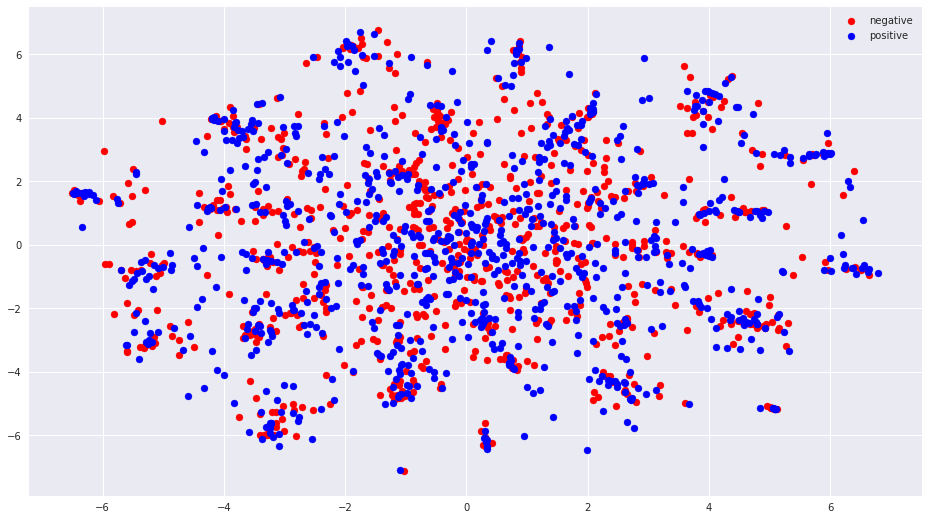

In [30]:
plt.figure(figsize=(16, 9))
colors = ['red','blue']
for no, i in enumerate(unique_label):
    plt.scatter(X[encoded==i,0],X[encoded==i,1],label=unique_label[no],color=colors[no])
plt.legend(['negative','positive'])
plt.show()